In [1]:
import os
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import PIL
from PIL import Image, ImageFilter
from torch.utils.data import DataLoader
import numpy as np
from tqdm.auto import tqdm

# seed everything
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DigitClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(DigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
@torch.no_grad()
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [4]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
    transforms.Lambda(lambda img : img.convert('RGB')),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=mnist_transform
)

# mnist_test_dataset = torch.utils.data.Subset(mnist_test_dataset, list(range(128)))
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=256, shuffle=False)

In [9]:
from diffusers import UNet2DModel
from pipeline_ddpm_custom import DDPMPipelineCustom
from scheduling_rectflow import RectFlowScheduler, RectFlowInverseScheduler

def get_beautifier_fixed_font(model_dir, classifier, device='cpu', font_='Helvetica', num_inverse_step=200, num_denoise_step=50, printed_digits_dir="./printed_digits"):
    printed_digits = {}
    total_fonts = 0
    total_images = 0
    for font in [font_]:
        font_path = os.path.join(printed_digits_dir, font)
        if os.path.isdir(font_path):
            total_fonts += 1  # Count fonts
            for digit in range(10):
                digit_folder = os.path.join(font_path, str(digit))
                if os.path.exists(digit_folder):
                    images = [
                        transforms.functional.to_tensor(
                            PIL.ImageOps.invert(Image.open(os.path.join(digit_folder, img_path)).resize((32, 32)).convert("RGB"))
                        ) * 2 - 1
                        for img_path in os.listdir(digit_folder)
                        if img_path.endswith(".png")
                    ]
                    total_images += len(images)
                    printed_digits.setdefault(digit, []).extend(images)
    

    unet = UNet2DModel.from_pretrained(f"{model_dir}/unet")
    scheduler_config_path = os.path.join(model_dir, "scheduler", "scheduler_config.json")
    scheduler = RectFlowScheduler.from_config(scheduler_config_path)
    scheduler_inv = RectFlowInverseScheduler.from_config(scheduler_config_path)
    unet.to(device)
    classifier.to(device)
    
    pipeline = DDPMPipelineCustom(
        unet=unet,
        scheduler=scheduler,
    )
    pipeline_inv = DDPMPipelineCustom(
        unet=unet,
        scheduler=scheduler_inv,
    )
    pipeline.set_progress_bar_config(disable=True)
    pipeline_inv.set_progress_bar_config(disable=True)
    class_conditioning = unet.class_embedding is not None
    
    @torch.no_grad()
    def beautifier(images, alpha):
        classifier.eval()
        _, labels = torch.max(classifier(images), 1)
        printed = torch.stack([
            printed_digits[label.item()][0]
            for (image, label) in zip(images, labels)
        ]).to(images.device)
        
        # Run noise inversion
        images = torch.cat([images, printed])
        labels = torch.cat([labels] * 2) if class_conditioning else None
        semantic_noise = pipeline_inv(labels, init_noise=images, clamp_output=False, num_inference_steps=num_inverse_step, output_type='pt').images
        z_images, z_printed = semantic_noise.chunk(2)

        # interpolation
        if not isinstance(alpha, list):
            interp_z = alpha * z_printed + (1 - alpha) * z_images
        
            # denoise from interpolated semantic noise
            labels = labels.chunk(2)[0] if class_conditioning else None
            interp = pipeline(labels, init_noise=interp_z * 2 - 1, num_inference_steps=num_denoise_step, output_type='pt').images
            return interp
        else:
            interp_z = torch.cat([a * z_printed + (1 - a) * z_images for a in alpha])
            labels = torch.cat([labels.chunk(2)[0]] * len(alpha)) if class_conditioning else None
            interp = pipeline(labels, init_noise=interp_z * 2 - 1, num_inference_steps=num_denoise_step, output_type='pt').images
            return interp
    
    return beautifier

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier = DigitClassifier(num_classes=10).to(device)
classifier.load_state_dict(torch.load("digit_classifier_mnist.pth", weights_only=True))
model = DigitClassifier(num_classes=10).to(device)
model.load_state_dict(torch.load("digit_classifier_printed.pth", weights_only=True))

figs = []
for config in ['cls_cnd_aug_printed', 'uncnd_aug_printed']:
    for alpha in [0.0, 0.05, 0.1, 0.15, 0.2]:
        print(f'Running {config} with alpha {alpha}')
        beautifier = get_beautifier_fixed_font(f'./output/{config}/', classifier, device)
        images = torch.stack([mnist_test_dataset[i][0] for i in range(5, 10)]).to(device)
        images = beautifier(images, alpha) if alpha > 0 else images * 0.5 + 0.5
        figs.append(images.cpu())

Running cls_cnd_aug_printed with alpha 0.0


/data/schu23/mldl/project/Handwriting-Beautification/diffusers/src/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'scheduling_rectflow.RectFlowScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/data/schu23/mldl/project/Handwriting-Beautification/diffusers/src/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'scheduling_rectflow.RectFlowInverseScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-pas

Running cls_cnd_aug_printed with alpha 0.05
Running cls_cnd_aug_printed with alpha 0.1
Running cls_cnd_aug_printed with alpha 0.15
Running cls_cnd_aug_printed with alpha 0.2
Running uncnd_aug_printed with alpha 0.0
Running uncnd_aug_printed with alpha 0.05
Running uncnd_aug_printed with alpha 0.1
Running uncnd_aug_printed with alpha 0.15
Running uncnd_aug_printed with alpha 0.2


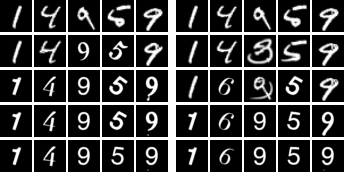

In [7]:
_, C, H, W = figs[0].shape
num_alpha = len(figs) // 2
col_gap = 2
row_gap = 3
rows = []
for i in range(num_alpha):
    row = []
    for j in range(2):
        for fig in figs[i+j*num_alpha]:
            row.append(fig)
            row.append(torch.ones(C, H, col_gap))
        row.append(torch.ones(C, H, col_gap*3))
    rows.append(torch.cat(row[:-2], dim=-1))
    rows.append(torch.ones(C, row_gap, rows[-1].size(-1)))
rows = torch.cat(rows[:-1], -2)

final = transforms.functional.to_pil_image(rows)
final.save('samples.jpeg')
final

In [29]:
figs = []
duration = 3 #sec
fps = 24
terminal_alpha = 0.3
num_samples = 10
for config in ['cls_cnd_aug_printed', 'uncnd_aug_printed', 'cls_cnd_no_aug', 'uncnd_no_aug']:
    for i in range(num_samples):
        print(f'Running {config} with sample {i}')
        images = mnist_test_dataset[i][0][None].to(device)
        beautifier = get_beautifier_fixed_font(f'./output/{config}/', classifier, device)
        images = beautifier(images, torch.linspace(0, terminal_alpha, duration * fps).tolist())
        figs.append(images.cpu())

Running cls_cnd_aug_printed with sample 0
Running cls_cnd_aug_printed with sample 1
Running cls_cnd_aug_printed with sample 2
Running cls_cnd_aug_printed with sample 3
Running cls_cnd_aug_printed with sample 4
Running cls_cnd_aug_printed with sample 5
Running cls_cnd_aug_printed with sample 6
Running cls_cnd_aug_printed with sample 7
Running cls_cnd_aug_printed with sample 8
Running cls_cnd_aug_printed with sample 9
Running uncnd_aug_printed with sample 0
Running uncnd_aug_printed with sample 1
Running uncnd_aug_printed with sample 2
Running uncnd_aug_printed with sample 3
Running uncnd_aug_printed with sample 4
Running uncnd_aug_printed with sample 5
Running uncnd_aug_printed with sample 6
Running uncnd_aug_printed with sample 7
Running uncnd_aug_printed with sample 8
Running uncnd_aug_printed with sample 9
Running cls_cnd_no_aug with sample 0
Running cls_cnd_no_aug with sample 1
Running cls_cnd_no_aug with sample 2
Running cls_cnd_no_aug with sample 3
Running cls_cnd_no_aug with samp

In [32]:
for i in range(num_samples):
    for j, config in enumerate(['cls_cnd_aug_printed', 'uncnd_aug_printed', 'cls_cnd_no_aug', 'uncnd_no_aug']):
        torchvision.io.write_video(
            f'video_results/{config}_{i}.mp4',
            figs[i+j*num_samples].permute(0, 2, 3, 1) * 255,
            fps,
            options={'crf': '18'})

In [33]:
!tar cvf video_results.tar video_results

video_results/
video_results/cls_cnd_no_aug_5.mp4
video_results/cls_cnd_no_aug_8.mp4
video_results/uncnd_no_aug_7.mp4
video_results/cls_cnd_aug_printed_4.mp4
video_results/cls_cnd_aug_printed_5.mp4
video_results/uncnd_aug_printed_9.mp4
video_results/uncnd_no_aug_8.mp4
video_results/uncnd_aug_printed_7.mp4
video_results/cls_cnd_aug_printed_2.mp4
video_results/uncnd_no_aug_3.mp4
video_results/cls_cnd_aug_printed_7.mp4
video_results/cls_cnd_no_aug_4.mp4
video_results/uncnd_aug_printed_5.mp4
video_results/cls_cnd_no_aug_3.mp4
video_results/uncnd_aug_printed_0.mp4
video_results/cls_cnd_no_aug_7.mp4
video_results/cls_cnd_aug_printed_9.mp4
video_results/uncnd_aug_printed_1.mp4
video_results/cls_cnd_no_aug_2.mp4
video_results/uncnd_aug_printed_8.mp4
video_results/uncnd_aug_printed_6.mp4
video_results/uncnd_aug_printed_4.mp4
video_results/uncnd_no_aug_1.mp4
video_results/cls_cnd_no_aug_0.mp4
video_results/cls_cnd_no_aug_1.mp4
video_results/uncnd_aug_printed_2.mp4
video_results/uncnd_no_aug_4.mp

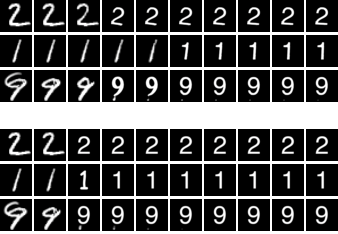

In [50]:
config_to_include_in_paper = ['cls_cnd_aug_printed', 'cls_cnd_no_aug']
target_samples = [1, 2, 9]
num_resample_frames = 10
rows = []
for j, config in enumerate(['cls_cnd_aug_printed', 'uncnd_aug_printed', 'cls_cnd_no_aug', 'uncnd_no_aug']):
    for i in target_samples:
        if config not in config_to_include_in_paper:
            continue
        frames = figs[i+j*num_samples]
        idx = torch.linspace(0, len(frames) - 1, num_resample_frames).floor().int()
        row = []
        for frame in frames[[idx]]:
            row.append(frame)
            row.append(torch.ones(C, H, col_gap))
        rows.append(torch.cat(row[:-1], -1))
        rows.append(torch.ones(C, row_gap, rows[-1].size(-1)))
    rows.append(torch.ones(C, row_gap * 4, rows[-1].size(-1)))
rows = torch.cat(rows[:-2], -2)
final = transforms.functional.to_pil_image(rows)
final.save('ablation-augment.jpeg')
final

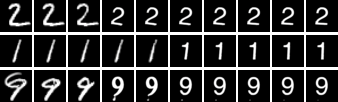

In [51]:
config_to_include_in_paper = ['cls_cnd_aug_printed']
target_samples = [1, 2, 9]
num_resample_frames = 10
rows = []
for j, config in enumerate(['cls_cnd_aug_printed', 'uncnd_aug_printed', 'cls_cnd_no_aug', 'uncnd_no_aug']):
    for i in target_samples:
        if config not in config_to_include_in_paper:
            continue
        frames = figs[i+j*num_samples]
        idx = torch.linspace(0, len(frames) - 1, num_resample_frames).floor().int()
        row = []
        for frame in frames[[idx]]:
            row.append(frame)
            row.append(torch.ones(C, H, col_gap))
        rows.append(torch.cat(row[:-1], -1))
        rows.append(torch.ones(C, row_gap, rows[-1].size(-1)))
rows = torch.cat(rows[:-1], -2)
final = transforms.functional.to_pil_image(rows)
final.save('teaser.jpeg')
final